In [35]:
import torch
import botorch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [38]:
opt_var_names = ['SOL1:solenoid_field_scale','CQ01:b1_gradient', 'SQ01:b1_gradient',
                 "QA01:b1_gradient", "QA02:b1_gradient", 
                 "QE01:b1_gradient", "QE02:b1_gradient", "QE03:b1_gradient", "QE04:b1_gradient"]
bounds = torch.as_tensor([[0.46, 0.485], [-0.02, 0.02], [-0.02, 0.02],
                       [-4, -1], [1, 4],
                       [-7,-1], [-1, 7],[-1, 7], [-7, 1]])

[[tensor([-1.2377, -1.1532, -1.1532, -0.9167, -0.9167, -0.9167, -0.9167, -0.9167,
        -0.9167, -0.9167, -0.9167, -0.9167, -0.9167, -0.9167, -0.9167, -0.8683,
        -0.8104, -0.8104, -0.8104, -0.8104, -0.8104, -0.8104, -0.8104, -0.8104,
        -0.8104, -0.8104, -0.8104, -0.8104, -0.8104, -0.7673, -0.7673]), tensor([-1.2694, -1.2694, -1.2694, -1.2694, -1.2694, -1.2694, -1.2694, -1.2694,
        -1.2694, -1.2694, -1.2694, -1.2694, -1.2694, -1.2694, -1.2694, -1.2694,
        -1.2374, -1.2374, -0.9694, -0.9694, -0.9694, -0.9694, -0.9679, -0.8247,
        -0.7304, -0.6965, -0.6965, -0.6965, -0.6722, -0.6722, -0.6722]), tensor([-1.3367, -1.3367, -1.3367, -1.2636, -1.2636, -1.1080, -1.0821, -1.0821,
        -0.9734, -0.9734, -0.9540, -0.9540, -0.9540, -0.8780, -0.8780, -0.8780,
        -0.8780, -0.8298, -0.8298, -0.7277, -0.7277, -0.7277, -0.7277, -0.7277,
        -0.7277, -0.7277, -0.7277, -0.6909, -0.6741, -0.6634, -0.6634])], [tensor([-1.2377, -0.7717, -0.7717, -0.7710, -0.6419, -0.6

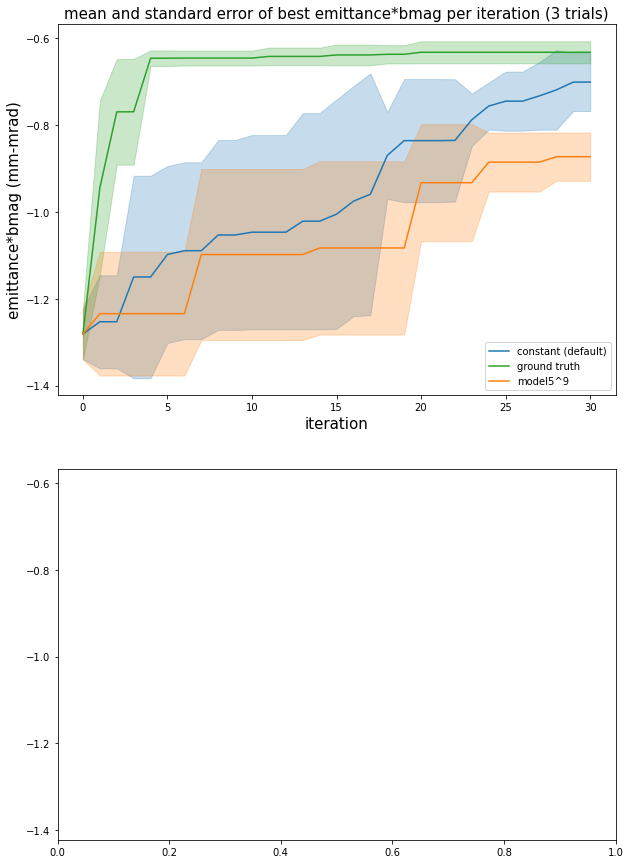

In [52]:
filenames = ['surr_const_model5_-5_2.0_2']

# plot best_y mean and std for each BO run
fig, axes = plt.subplots(2, 1, sharey=True)

colors = ['C0','C2','C1','C3','C1']

transformer_x = botorch.models.transforms.input.Normalize(9, bounds = bounds.transpose(0,1))
for file, ax in enumerate(fig.axes):
    if file >= len(filenames):
        break
        
    BO_data_dict = torch.load('./results/'+filenames[file]+'.pt')
    x_configs = BO_data_dict['x_configs']
    best_y_lists = BO_data_dict['best_y_lists']
    print(best_y_lists)
    BO_runs = BO_data_dict['BO_runs']
    for i in range(2, len(BO_runs)):
        BO_runs[i] = BO_runs[i][:6] + '^9'
    run_BO = BO_data_dict['run_BO']

    n_trials = len(best_y_lists[0])
    n_steps = len(best_y_lists[0][0])
    
    ax.set_title(f'mean and standard error of best emittance*bmag per iteration ({n_trials} trials)', fontsize=15)
    x = torch.arange(n_steps)
    ax.set_xlabel('iteration', fontsize=15)
    ax.set_ylabel('emittance*bmag (mm-mrad)', fontsize=15)
    
    for i in range(len(BO_runs)):
        if run_BO[i] == True:
            best_y_list = torch.stack(best_y_lists[i], dim=0)
            mean = torch.mean(best_y_list, dim=0).detach()
            std_error = torch.std(best_y_list, dim=0).detach() / torch.sqrt(torch.tensor(n_trials))
            ax.plot(x, mean, label=BO_runs[i], c = colors[i])
            ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
            ax.fill_between(x, mean - 2*std_error, mean + 2*std_error, alpha=0.25, color = colors[i])
    ax.legend(loc = 'lower right')
    
# fig.legend()
fig.set_size_inches(10, 15)
# fig.tight_layout()
fig.savefig(f'BO-plots/{filenames[0]}.png')


# BO_data_dict = torch.load('./results/'+filenames[0]+'.pt')
# x_configs = BO_data_dict['x_configs']
# BO_runs = BO_data_dict['BO_runs']
# run_BO = BO_data_dict['run_BO']

# fig, axes = plt.subplots(3, 3)
# fig.set_size_inches(20, 10)

# for file, ax in enumerate(fig.axes):
#     if file >= len(x_configs):
#         break
    
#     if run_BO[file] == True:
#         normed_x_config = transformer_x(x_configs[file])
#         for i in range(len(opt_var_names)):
#             ax.set_title(BO_runs[file])
#             ax.set_xlabel('iter')
#             ax.set_ylabel('value chosen by acq (normalized)')
#             ax.plot(normed_x_config[:,i], label = opt_var_names[i])

# plt.legend(bbox_to_anchor=(1.1, 1.05))    
# fig.savefig(f'BO-plots/{filename}_scan.png')